# Crunchbase Data Science Challenge
The objective of this exercise is to create a recommendation algorithm to server the user base with relevant and personalized articles. 
- [Exploratory Data Analysis](#eda)
- [Featurize Pageviews](#featurization)
- [User Retention](#user_retention)
- [Feature Hashing](#feature_hashing)
- [Building User Matrix](#user_matrix)
- [Gram Matrix For User-User Similarity](#gram_matrix)
- [Recommendation Algorithm](#reco_algo)
- [Summary and Next Steps](#next_steps)

In [1]:
# Import dependencies & display configuration
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlparse
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.metrics.pairwise import cosine_similarity

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', 50)

<a id='eda'></a>
# Exploratory Data Analysis

In [2]:
# Data wrangling and featurization
pageviews = pd.read_csv("~/Desktop/data/pageviews.csv", 
                        index_col=0, 
                        parse_dates=[2]) \
    .rename(columns={'time': 'created_at'})
users = pd.read_csv("~/Desktop/data/users.csv", 
                    index_col=0, 
                    parse_dates=[2])

# Add created_at dates
users['created_at_date'] = pd.to_datetime(users.created_at.dt.strftime('%Y-%m-%d'))
pageviews['created_at_date'] = pd.to_datetime(pageviews.created_at.dt.strftime('%Y-%m-%d'))

# Verify the same user_ids exist in each dataset
assert pageviews.user_id.nunique() == users.user_id.nunique()
assert np.all(np.isin(pageviews.user_id.unique(), users.user_id.unique()))

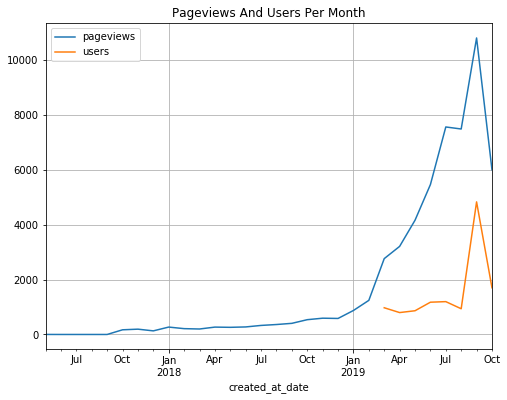

In [3]:
# Examine growth of datasets over time
pageviews.groupby('created_at_date').size().resample('M').sum() \
    .plot(grid=True, figsize=(8, 6), label='pageviews');
users.groupby('created_at_date').size().resample('M').sum() \
    .plot(grid=True, figsize=(8, 6), label='users');

plt.title('Pageviews And Users Per Month');
plt.legend();

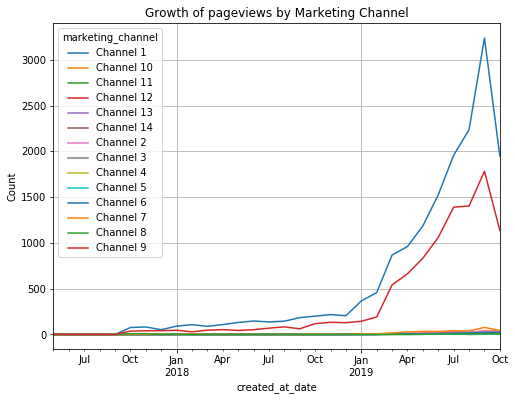

In [4]:
# Examine marketing channel of pageviews to determine sources of growth
pageviews[['created_at_date', 'user_id', 'marketing_channel']] \
    .drop_duplicates() \
    .groupby(['created_at_date', 'marketing_channel']).size() \
    .unstack('marketing_channel').resample('M').sum().plot(grid=True, figsize=(8,6));
plt.title('Growth of pageviews by Marketing Channel');
plt.ylabel('Count');

In [5]:
# Check for missing data
print(f'pageviews shape = {pageviews.shape}')
print(f'users shape = {users.shape}')
print()

print(pageviews.isna().sum())
print()
print(users.isna().sum())

pageviews shape = (54285, 9)
users shape = (12461, 6)

user_id                 0
created_at              0
marketing_channel       0
path                    0
path_by_page_type    2257
path_by_domain          0
article_url             0
article_title           0
created_at_date         0
dtype: int64

user_id                0
created_at             0
job_function       10754
job_industry       10837
use_case            9919
created_at_date        0
dtype: int64


In [6]:
# Num unique values per column
print(pageviews.nunique().sort_values(ascending=False))
print()
print(users.nunique().sort_values(ascending=False))

created_at           54285
article_url          42545
article_title        41293
path                 31585
user_id              12461
created_at_date        714
marketing_channel       14
path_by_page_type        6
path_by_domain           3
dtype: int64

created_at         12461
user_id            12461
created_at_date      232
job_industry          32
job_function          10
use_case               8
dtype: int64


<a id='featurization'></a>
# Featurize Pageviews

In [7]:
# Featurize pageviews
pageviews['website'] = pageviews.article_url.apply(lambda url: urlparse(url).netloc)
pageviews['page_rank'] = pageviews.groupby('user_id')['created_at'].rank('first')
pageviews['total_pageviews'] = pageviews.groupby('user_id')['page_rank'].transform('max')
pageviews['visit_number'] = pageviews.groupby('user_id')['created_at_date'].rank('dense')
pageviews['first_visit_date'] = pageviews.groupby('user_id')['created_at_date'].transform('min')

pageviews['user_cohort'] = pageviews.groupby('user_id')['created_at_date'].transform('min').dt.strftime('%Y-%m-01').map(pd.to_datetime)
pageviews['is_first_page'] = pageviews.page_rank == 1
pageviews['is_first_visit'] = pageviews.visit_number == 1
pageviews['num_visits'] = pageviews.groupby('user_id')['visit_number'].transform('max')
pageviews['last_visit_date'] = pageviews.groupby('user_id')['created_at_date'].transform('max')

pageviews = pd.merge(pageviews,
                     pageviews[pageviews.page_rank == 1][['user_id', 'marketing_channel']].drop_duplicates()
                     .rename(columns={'marketing_channel': 'acquisition_channel'}),
                     on='user_id',
                     how='left')

pageviews['days_since_first_visit'] = (pageviews.created_at_date - pageviews.first_visit_date).dt.days
pageviews['customer_lifetime'] = (pageviews.last_visit_date - pageviews.first_visit_date).dt.days
pageviews.sample(5)

,user_id,created_at,marketing_channel,path,path_by_page_type,path_by_domain,article_url,article_title,created_at_date,website,page_rank,total_pageviews,visit_number,first_visit_date,user_cohort,is_first_page,is_first_visit,num_visits,last_visit_date,acquisition_channel,days_since_first_visit,customer_lifetime
33937,dde25de9-7297-4ab0-ad33-7d073e04d35a,2019-07-04 09:11:47.079,Channel 1,qlubzdjnafnrosen,Organizations,Main Site,https://www.bbc.com/news/business-48271553,Virgin mobile service restored after outage,2019-07-04,www.bbc.com,4.0,5.0,3.0,2019-02-26,2019-02-01,False,False,3.0,2019-07-04,Channel 1,128,128
7257,926125f6-6161-483a-9a24-b7534f27fe34,2019-03-04 14:32:20.636,Channel 1,aokdhuceknebnkif,Acquisition,Main Site,https://www.caci.co.uk/news/press-release/caci...,CACI continues growth with acquisition of Rock...,2019-03-04,www.caci.co.uk,1.0,1.0,1.0,2019-03-04,2019-03-01,True,True,1.0,2019-03-04,Channel 1,0,0
37496,fab83ab4-6332-467c-9dbb-1b5e10b87b40,2019-09-05 17:47:10.088,Channel 1,tcxgabzoyflzacpz,People,Main Site,http://www.huffingtonpost.com/vala-afshar/work...,Workday CEO: 10 Powerful Business Leadership L...,2019-09-05,www.huffingtonpost.com,2.0,2.0,2.0,2019-09-02,2019-09-01,False,False,2.0,2019-09-05,Channel 1,3,3
22991,de81d592-7350-4dbb-a54d-d3bfd9e80652,2019-09-26 08:05:41.022,Channel 9,pefmkcejkbczgdyh,Search,Main Site,https://www.desmoinesregister.com/story/news/l...,"After son's death, Ankeny mother seeks to end ...",2019-09-26,www.desmoinesregister.com,3.0,5.0,1.0,2019-09-26,2019-09-01,False,True,1.0,2019-09-26,Channel 9,0,0
5818,d206a4c8-49d7-4022-afec-a0f48516e7b6,2019-02-27 17:04:57.718,Channel 1,tvxtylsjpkyqqxvw,Funding Round,Main Site,https://techcrunch.com/2017/06/06/the-realreal...,The RealReal ropes in $50 million in new funding,2019-02-27,techcrunch.com,77.0,196.0,6.0,2019-02-20,2019-02-01,False,False,10.0,2019-03-05,Channel 1,7,13


In [8]:
# Examine effect of marketing chanel on customer lifetime
pageviews[['user_id', 'acquisition_channel', 'customer_lifetime']].drop_duplicates() \
    .groupby('acquisition_channel').customer_lifetime.describe() \
    .sort_values('count', ascending=False)

,count,mean,std,min,25%,50%,75%,max
acquisition_channel,,,,,,,,
Channel 1,8173.0,37.104735,97.411765,0.0,0.0,0.0,16.00,736.0
Channel 9,3600.0,36.360000,96.062216,0.0,0.0,0.0,18.00,735.0
Channel 7,163.0,30.588957,91.111161,0.0,0.0,0.0,7.00,696.0
Channel 10,104.0,20.923077,48.268000,0.0,0.0,0.0,9.50,222.0
Channel 2,102.0,9.980392,26.090467,0.0,0.0,0.0,5.75,179.0
Channel 12,64.0,28.890625,60.112624,0.0,0.0,1.0,43.00,345.0
Channel 14,53.0,27.188679,60.691546,0.0,0.0,0.0,19.00,317.0
Channel 3,50.0,12.360000,38.588758,0.0,0.0,0.0,0.00,242.0
Channel 13,48.0,6.583333,16.052882,0.0,0.0,0.0,1.50,87.0


In [9]:
# Examine effect of marketing chanel on total pageviews per customer
pageviews[['user_id', 'acquisition_channel', 'total_pageviews']].drop_duplicates() \
    .groupby('acquisition_channel').total_pageviews.describe().sort_values('count', ascending=False)

,count,mean,std,min,25%,50%,75%,max
acquisition_channel,,,,,,,,
Channel 1,8173.0,4.085036,16.153267,1.0,1.0,1.0,3.00,760.0
Channel 9,3600.0,5.158889,19.098428,1.0,1.0,2.0,4.00,542.0
Channel 7,163.0,3.779141,8.095895,1.0,1.0,1.0,3.00,61.0
Channel 10,104.0,2.663462,5.559232,1.0,1.0,1.0,2.00,51.0
Channel 2,102.0,3.852941,7.554943,1.0,1.0,2.0,3.00,58.0
Channel 12,64.0,3.734375,5.283223,1.0,1.0,2.0,3.00,32.0
Channel 14,53.0,3.867925,5.663777,1.0,1.0,2.0,4.00,32.0
Channel 3,50.0,3.040000,4.090606,1.0,1.0,1.5,3.00,25.0
Channel 13,48.0,1.958333,1.761990,1.0,1.0,1.0,2.00,10.0


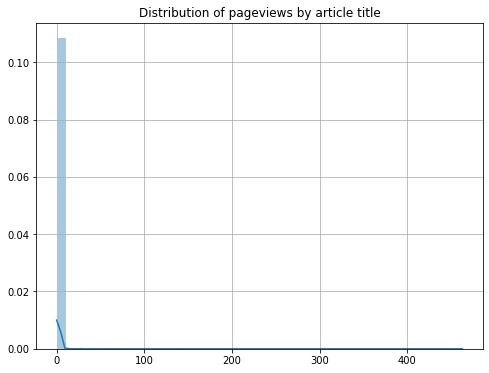

In [10]:
# Examine frequency of each article's views
plt.figure(figsize=(8, 6))
sns.distplot(pageviews.groupby('article_title').size())
plt.grid()
plt.title('Distribution of pageviews by article title');

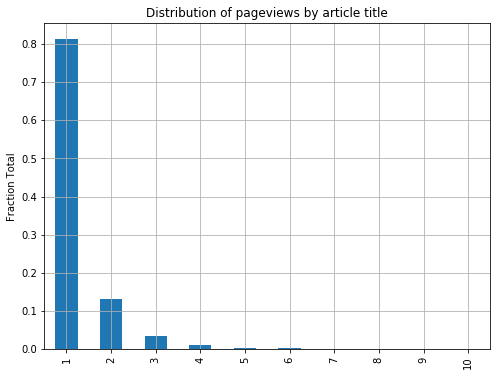

In [11]:
# Most articles have only been viewed once
pageviews.groupby('article_title').size().value_counts(normalize=True) \
    .head(10).plot(kind='bar', grid=True, figsize=(8, 6));
plt.title('Distribution of pageviews by article title');
plt.ylabel('Fraction Total');

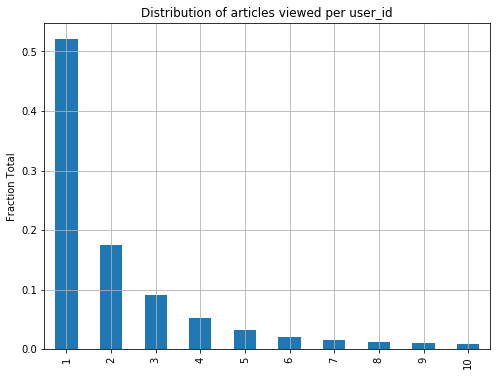

In [12]:
# Most users only view one article
pageviews.groupby('user_id').article_title.nunique().value_counts(normalize=True).head(10) \
    .plot(kind='bar', grid=True, figsize=(8, 6));
plt.title('Distribution of articles viewed per user_id');
plt.ylabel('Fraction Total');

<a id='user_retention'></a>
# User Retention

In [13]:
# Examine user retention

def get_retention_cohort(val):
    dayz = [0, 30, 60, 90, 120, 180, np.inf]
    for day in dayz:
        if val <= day:
            return day


pageviews['retention_cohort'] = pageviews.days_since_first_visit.map(get_retention_cohort)

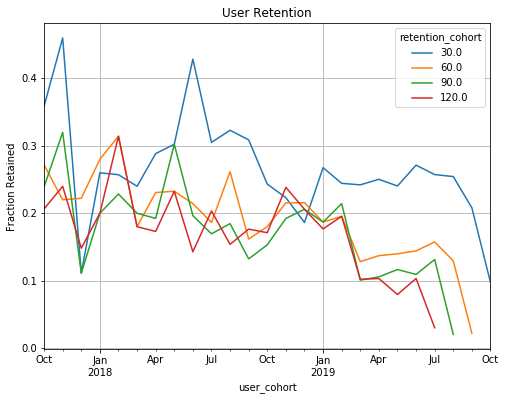

In [14]:
df = pageviews.groupby(['user_cohort', 'retention_cohort'])['user_id'].nunique().unstack('retention_cohort')
cohortz = df.loc[:, 0.0].copy()

df_2 = df.loc[:, 30.0:120.0].div(cohortz.values, axis=0)
df_2['2017-07':].plot(grid=True, figsize=(8,6));
plt.title('User Retention');
plt.ylabel('Fraction Retained');

In [15]:
# Apply 30-day Half-Life to pageviews
HALF_LIFE = 30

pageviews['delta_t'] = (pageviews.created_at_date.max() - pageviews.created_at_date).dt.days
pageviews['page_value'] = pageviews.delta_t.map(lambda val: 0.5**(val / HALF_LIFE))
pageviews['num_title_words'] = pageviews.article_title.map(lambda title: len(title.split(' ')))

<a id='feature_hashing'></a>
# Feature Hashing
This technique differs from classic td-idf based vectorization in that the hashed feature values as the indices. While there is the danger of hashing collisions, we can map the features to a smaller dimension with richer (float) values. This technique is valuable for clustering algorithms as well as we can avoid the curse of dimentionality.

In [16]:
# Featurize pageviews using article title
N_FEATURES = 512

vectorizer = HashingVectorizer(stop_words='english',
                               ngram_range=(1, 2),
                               strip_accents='unicode',
                               n_features=N_FEATURES)

<a id='user_matrix'></a>
# Build User Matrix
In this step, we will build a feature matrix for each user, using the hashing vectorizer and the page values computed with HALF_LIFE variable

In [17]:
# inititalize dataframe with article titles and hash titles
df = pd.DataFrame(data=pageviews.article_title.drop_duplicates())
df_2 = pd.DataFrame(vectorizer.fit_transform(df['article_title']).toarray()).set_index(df.article_title.values)

# Keep page value which is reflection of HALF_LIFE
df_3 = pageviews[['user_id', 'article_title', 'page_value']].copy()

df_4 = pd.merge(df_3, df_2, left_on='article_title', right_index=True, how='left') \
    .drop(columns=['article_title']) \
    .set_index(['user_id', 'page_value'])

df_5 = df_4.multiply(df_4.index.get_level_values('page_value'), axis=0) \
    .reset_index().drop(columns=['page_value'])

# For each user, just average the features
df_6 = df_5.groupby('user_id').mean()

df_6.iloc[:5, :10]

,0,1,2,3,4,5,6,7,8,9
user_id,,,,,,,,,,
0005f1a8-2fed-4ddf-912e-25c4b09832ea,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
0015c201-e502-46b3-8a1d-65c03cb1d94f,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
0015cfcd-ed7b-4a16-b88b-fd33d3fa2d74,0.00000,0.0,0.0,0.000000,0.000457,0.0,0.0,0.000000,0.0,0.0
0019a789-9744-4efd-8f45-c9c37cb12fdd,-0.00179,0.0,0.0,-0.001314,0.000000,0.0,0.0,-0.001579,0.0,0.0
002dd14d-3412-46bc-affb-f374f810c7fc,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0


In [18]:
# Normalize each row to have unit norm and compute gram matrix (cosine similarity)

user_matrix = pd.DataFrame(index=df_6.index, data=Normalizer().fit_transform(df_6))
gram_matrix = pd.DataFrame(index=user_matrix.index, 
                           columns=user_matrix.index.values, 
                           data=cosine_similarity(user_matrix))

<a id='gram_matrix'></a>
# Gram Matrix
This data structure contains the cosine similarities between every user. Different distance metrics (such as Euclidean distance) could also be tested.

In [19]:
gram_matrix.iloc[:5, :5]

,0005f1a8-2fed-4ddf-912e-25c4b09832ea,0015c201-e502-46b3-8a1d-65c03cb1d94f,0015cfcd-ed7b-4a16-b88b-fd33d3fa2d74,0019a789-9744-4efd-8f45-c9c37cb12fdd,002dd14d-3412-46bc-affb-f374f810c7fc
user_id,,,,,
0005f1a8-2fed-4ddf-912e-25c4b09832ea,1.000000,0.000000,0.071067,0.000000,-0.009277
0015c201-e502-46b3-8a1d-65c03cb1d94f,0.000000,1.000000,0.000000,-0.039562,0.000000
0015cfcd-ed7b-4a16-b88b-fd33d3fa2d74,0.071067,0.000000,1.000000,0.035785,0.073727
0019a789-9744-4efd-8f45-c9c37cb12fdd,0.000000,-0.039562,0.035785,1.000000,0.059270
002dd14d-3412-46bc-affb-f374f810c7fc,-0.009277,0.000000,0.073727,0.059270,1.000000


<a id='reco_algo'></a>
# Recommendation Algorithm

In [20]:
# Get Recommendations
user_id = users.sample(1)['user_id'].values[0]
print(f'user_id = {user_id}')

user_article_titles = pageviews[pageviews.user_id == user_id].article_title.unique()
print(user_article_titles)

similarity_values = gram_matrix.loc[user_id].to_frame('user_similarity')
page_values = pd.merge(pageviews[['user_id', 'article_title', 'page_value']].copy(), similarity_values,
                       left_on='user_id', right_index=True, how='left')
page_values['score'] = page_values.page_value * page_values.user_similarity

recs = page_values.groupby('article_title').score.mean().sort_values(ascending=False).to_frame('score')

# Remove articles the user has already clicked on
mask = np.isin(recs.index.values, np.array(user_article_titles))
recs = recs[~mask]
print(recs)

user_id = cfd47e99-5d01-4bba-b74e-c581eeb24612
['How Huel keeps on growing – despite its questionable taste']
                                                       score
article_title                                               
Siemens gives a new address for Next47 in Benga...  0.254464
Permira Closes Permira V at €5.3 Billion            0.179077
How to shop at Grove Collaborative, the site th...  0.154667
HighWire Press Receives Majority Equity Investm...  0.152144
mimik Appoints Kai Buehler as Chief Marketing O...  0.142273
...                                                      ...
RateGain Buys DHISCO to Expand Its Hospitality ... -0.139551
Grupo LALA and Groupe Lactalis Reach an Agreeme... -0.145273
The Science Behind Why Rocking Sends You to Sleep  -0.156716
Apps Really Can Help You Get Better Sleep (Some... -0.156716
Sleep Easily Introduces New Sleep Solution         -0.156716

[41292 rows x 1 columns]


                                                       score  trunc_score
article_title                                                            
Siemens gives a new address for Next47 in Benga...  0.254464        0.254
Permira Closes Permira V at €5.3 Billion            0.179077        0.179
How to shop at Grove Collaborative, the site th...  0.154667        0.155
HighWire Press Receives Majority Equity Investm...  0.152144        0.152
mimik Appoints Kai Buehler as Chief Marketing O...  0.142273        0.142
What in the world is TripActions?                   0.135010        0.135
Supermicro：ハッカーが企業サーバーを乗っ取り、データを盗むことができる新しい重大なセ...  0.120756        0.121
With A $170 Million Investment, Koenigsegg Gain...  0.117215        0.117
Houzz Acquires Home And Gardening Community Sit...  0.115561        0.116
Deal-Monitor Deutsche Bank investiert in Finanz...  0.115149        0.115
btov Partners closes €80M fund aimed at industr...  0.114341        0.114
Washmen raises $6.2 million Series B  

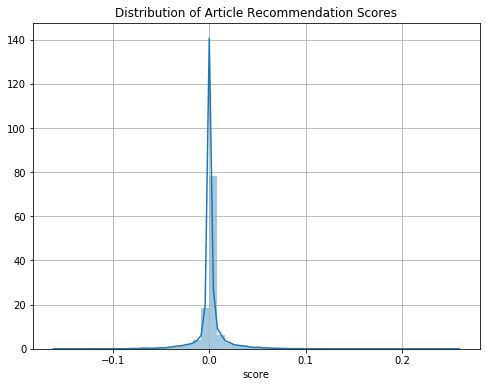

In [21]:
# Remove articles that are very similar
N_DIGITS = 3

recs_2 = recs.copy()
recs_2['trunc_score'] = recs_2.score.round(N_DIGITS)
recs_2 = recs_2.drop_duplicates(subset='trunc_score')
print(recs_2.head(15))

# Plot distribution of article scores
plt.figure(figsize=(8, 6))
sns.distplot(recs.score);
plt.title('Distribution of Article Recommendation Scores');
plt.grid()

<a id='next_steps'></a>
# Summary and Next Steps

- The algorithm currently has 3 main parameters: N_FEATURES, HALF-LIFE, and N_DIGITS. These parameters are all able to balance the exploration v. exploitation for generating recommendations. 
- Further, we must tune the number of recommendations that are displayed to the user (N_RECS).
- In terms of next steps, there are several ways to generate more user features that can be fed into the gram matrix:
<ol>
<li> Use web-scraping to create a corpus of the actual articles. Here, I am only using the article titles.</li>
<li> Featurize the the session data as well as the article title data. For example, we could use acquisition channel, crunchbase website page hierarchy, number of pages viewed, time spent on website, etc.</li>
<li> Different algorithms can be tested, such as Recurrent Neural Networks to generate sequence recommendations.</li>
</ol>
- We must have a way to determine if the recommendation algorithm is working by monitoring relevant metrics such as articles view and user retention. We could do A/B testing to see if this algorithm outperforms, say, a model that just recommends the most popular articles.
- Ultimately, this algorithm could be more personalized to the user based on the type of articles they click on. We could generate affinity scores for **exploration** and **exploitation** as opposed to the N_DIGITS paramter.
- The website data column in the pageviews can be used to create an embedding vector. This would be useful if we want to include new websites for articles.
- We can use the feature matrix to develop **personas** to aid in marketing efforts.